## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import os, gc
import shutil
import time, datetime
from thop import profile, clever_format
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


In [ ]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
assert False, "Stop execution of next cell!"

AssertionError: Stop execution of next cell!

## Single Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=1
model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:13<00:00, 12343185.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter1_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter1_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter1_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter1_capsnet_cifar10_model'
pruned_25p_multilayer_inter1_capsnet_cifar10_model=pruned_25p_multilayer_inter1_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter1_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/25 03:28:33 AM | pruned_25p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7265, Top 1 Acc=18.75, Top 5 Acc=50.00
INFO:capsnet:pruned_25p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7265, Top 1 Acc=18.75, Top 5 Acc=50.00
01/25 03:28:38 AM | pruned_25p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6373, Top 1 Acc=20.27, Top 5 Acc=65.25
INFO:capsnet:pruned_25p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6373, Top 1 Acc=20.27, Top 5 Acc=65.25
01/25 03:28:42 AM | pruned_25p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5404, Top 1 Acc=28.70, Top 5 Acc=75.34
INFO:capsnet:pruned_25p_multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5404, Top 1 Acc=28.70, Top 5 Acc=75.34
01/25 03:28:46 AM | pruned_25p_multilayer_inter1_capsnet_cifar10_model Trai

CPU times: user 1h 44min 39s, sys: 4min 25s, total: 1h 49min 4s
Wall time: 1h 48min 54s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

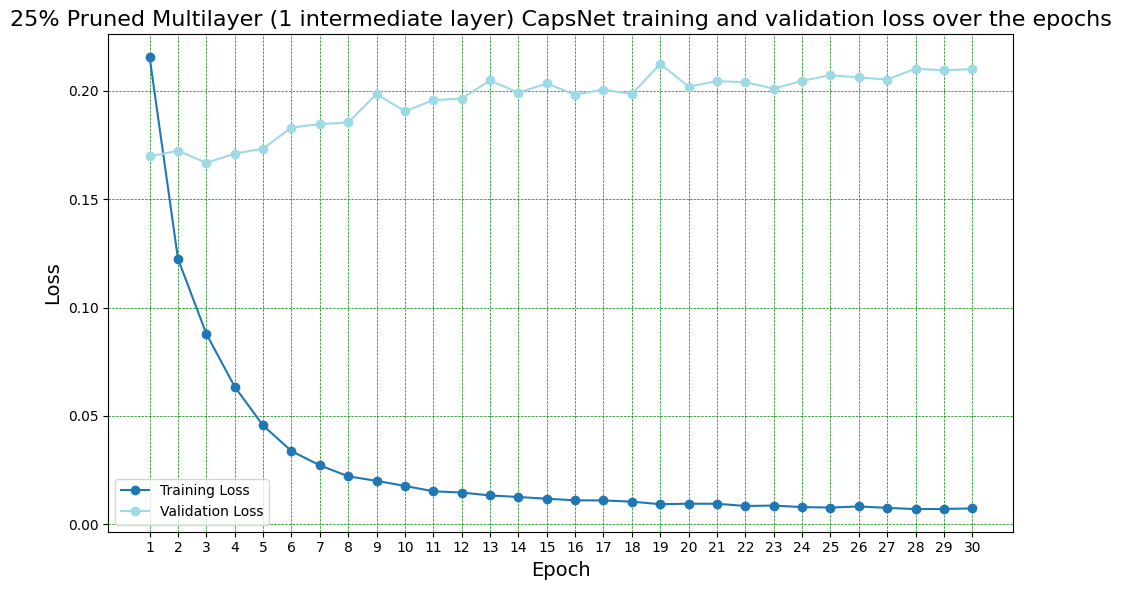

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (1 intermediate layer) CapsNet training and validation loss over the epochs')

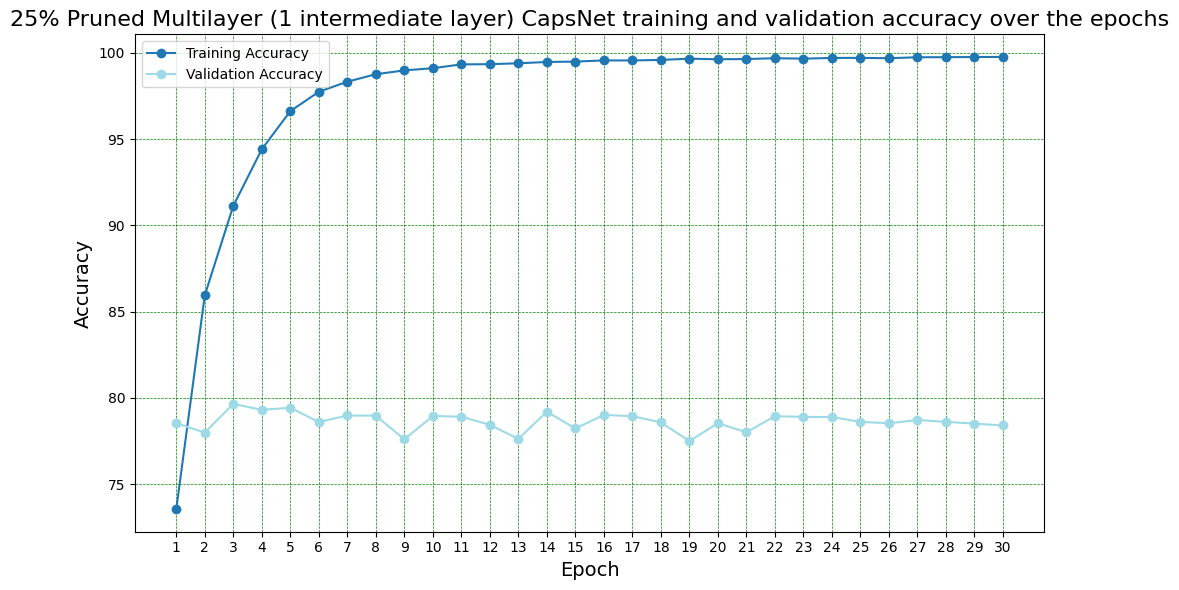

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (1 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=2

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:05<00:00, 29041501.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAgg

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter2_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter2_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter2_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter2_capsnet_cifar10_model'
pruned_25p_multilayer_inter2_capsnet_cifar10_model=pruned_25p_multilayer_inter2_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter2_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/25 06:40:54 PM | pruned_25p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7240, Top 1 Acc=9.38, Top 5 Acc=46.88
INFO:capsnet:pruned_25p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7240, Top 1 Acc=9.38, Top 5 Acc=46.88
01/25 06:40:59 PM | pruned_25p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6684, Top 1 Acc=16.29, Top 5 Acc=64.02
INFO:capsnet:pruned_25p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6684, Top 1 Acc=16.29, Top 5 Acc=64.02
01/25 06:41:03 PM | pruned_25p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5702, Top 1 Acc=23.80, Top 5 Acc=72.16
INFO:capsnet:pruned_25p_multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5702, Top 1 Acc=23.80, Top 5 Acc=72.16
01/25 06:41:09 PM | pruned_25p_multilayer_inter2_capsnet_cifar10_model Traini

CPU times: user 1h 47min 58s, sys: 7min 20s, total: 1h 55min 19s
Wall time: 1h 56min 20s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter2_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

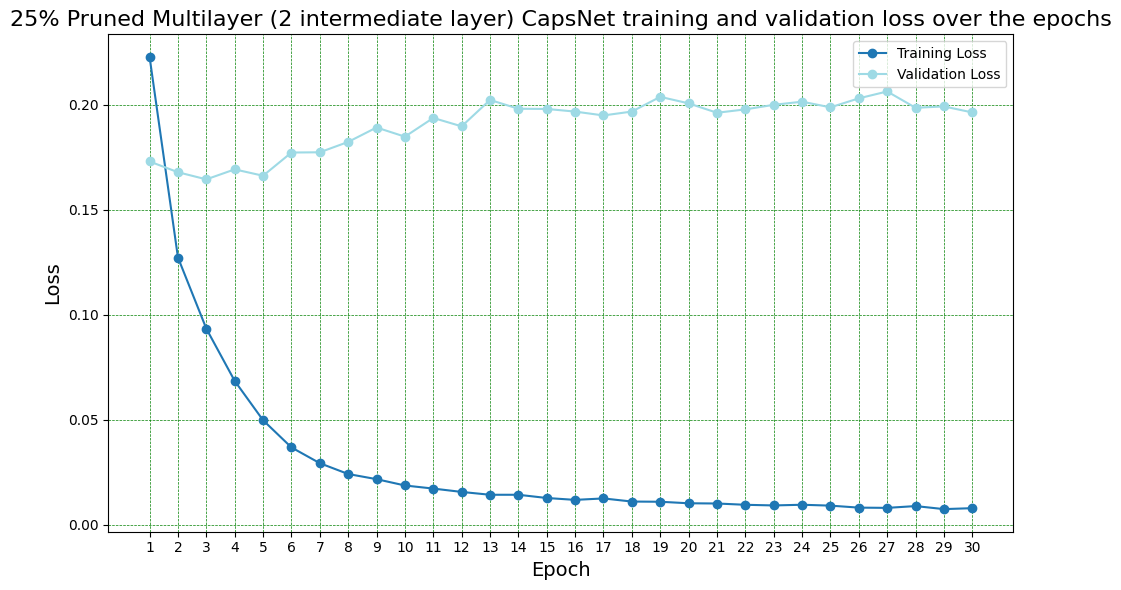

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (2 intermediate layer) CapsNet training and validation loss over the epochs')

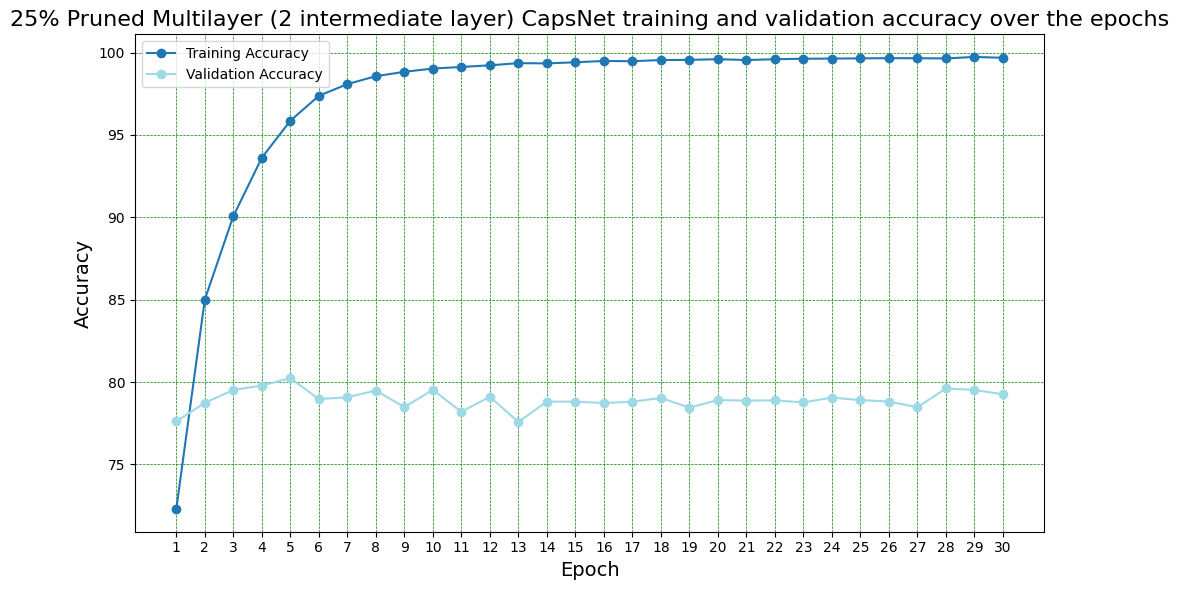

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (2 intermediate layer) CapsNet training and validation accuracy over the epochs')

In [ ]:
from google.colab import runtime
runtime.unassign()

## 3 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=3

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:05<00:00, 29555793.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
 

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter3_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter3_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter3_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter3_capsnet_cifar10_model'
pruned_25p_multilayer_inter3_capsnet_cifar10_model = pruned_25p_multilayer_inter3_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): 

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_25p_multilayer_inter3_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/25 08:56:04 PM | pruned_25p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7253, Top 1 Acc=12.50, Top 5 Acc=40.62
INFO:capsnet:pruned_25p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7253, Top 1 Acc=12.50, Top 5 Acc=40.62
01/25 08:56:09 PM | pruned_25p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6810, Top 1 Acc=15.44, Top 5 Acc=60.80
INFO:capsnet:pruned_25p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6810, Top 1 Acc=15.44, Top 5 Acc=60.80
01/25 08:56:15 PM | pruned_25p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5921, Top 1 Acc=21.78, Top 5 Acc=68.70
INFO:capsnet:pruned_25p_multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5921, Top 1 Acc=21.78, Top 5 Acc=68.70
01/25 08:56:20 PM | pruned_25p_multilayer_inter3_capsnet_cifar10_model Trai

CPU times: user 2h 13min 25s, sys: 8min 31s, total: 2h 21min 57s
Wall time: 2h 21min 38s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter3_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

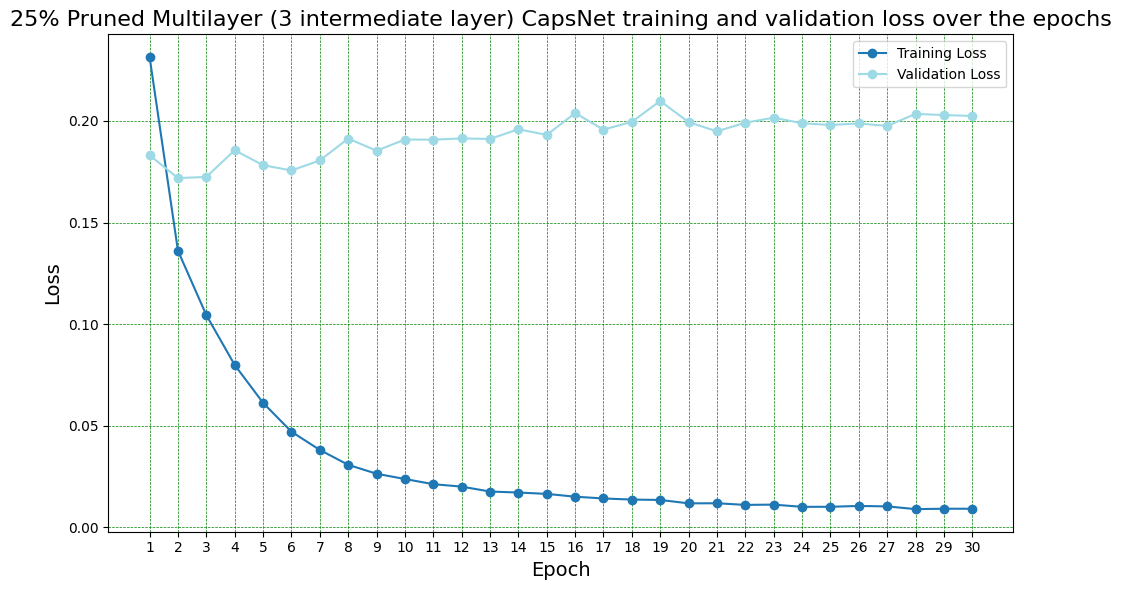

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (3 intermediate layer) CapsNet training and validation loss over the epochs')

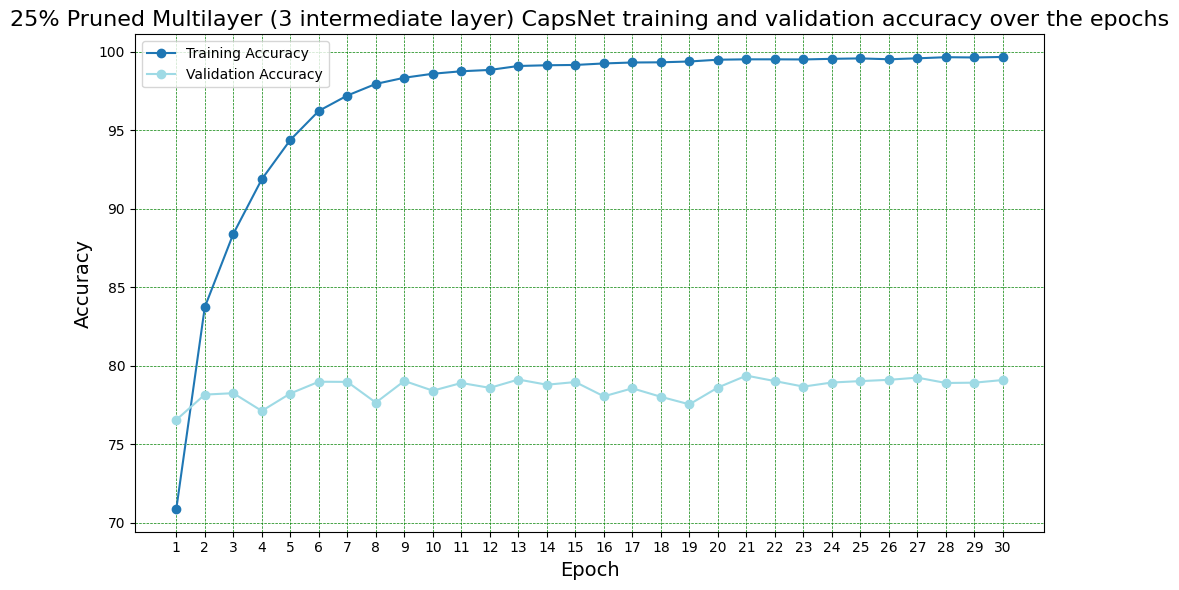

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (3 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=4

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter4_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter4_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter4_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter4_capsnet_cifar10_model'
pruned_25p_multilayer_inter4_capsnet_cifar10_model = pruned_25p_multilayer_inter4_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_25p_multilayer_inter4_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/25 11:24:19 PM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7219, Top 1 Acc=6.25, Top 5 Acc=56.25
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7219, Top 1 Acc=6.25, Top 5 Acc=56.25
01/25 11:24:25 PM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6972, Top 1 Acc=15.06, Top 5 Acc=59.56
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6972, Top 1 Acc=15.06, Top 5 Acc=59.56
01/25 11:24:32 PM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6166, Top 1 Acc=20.91, Top 5 Acc=68.99
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6166, Top 1 Acc=20.91, Top 5 Acc=68.99
01/25 11:24:39 PM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Traini

CPU times: user 1h 19min 17s, sys: 4min 59s, total: 1h 24min 17s
Wall time: 1h 24min 6s


Checkpoint restart

In [ ]:
%%time
n_epochs = 30

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter4_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

01/26 12:51:57 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.0079, Top 1 Acc=100.00, Top 5 Acc=100.00
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.0079, Top 1 Acc=100.00, Top 5 Acc=100.00
01/26 12:52:04 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0142, Top 1 Acc=99.24, Top 5 Acc=99.72
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0142, Top 1 Acc=99.24, Top 5 Acc=99.72
01/26 12:52:10 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.0144, Top 1 Acc=99.09, Top 5 Acc=99.86
INFO:capsnet:pruned_25p_multilayer_inter4_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.0144, Top 1 Acc=99.09, Top 5 Acc=99.86
01/26 12:52:17 AM | pruned_25p_multilayer_inter4_capsnet_cifar10_

CPU times: user 1h 19min 59s, sys: 5min 3s, total: 1h 25min 2s
Wall time: 1h 24min 50s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter4_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

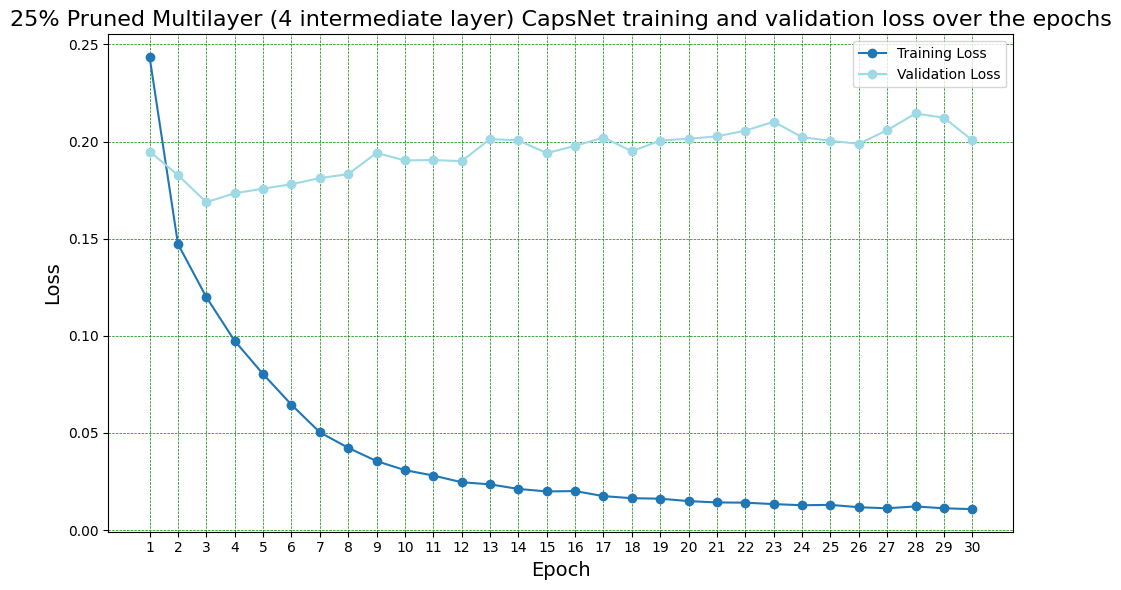

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (4 intermediate layer) CapsNet training and validation loss over the epochs')

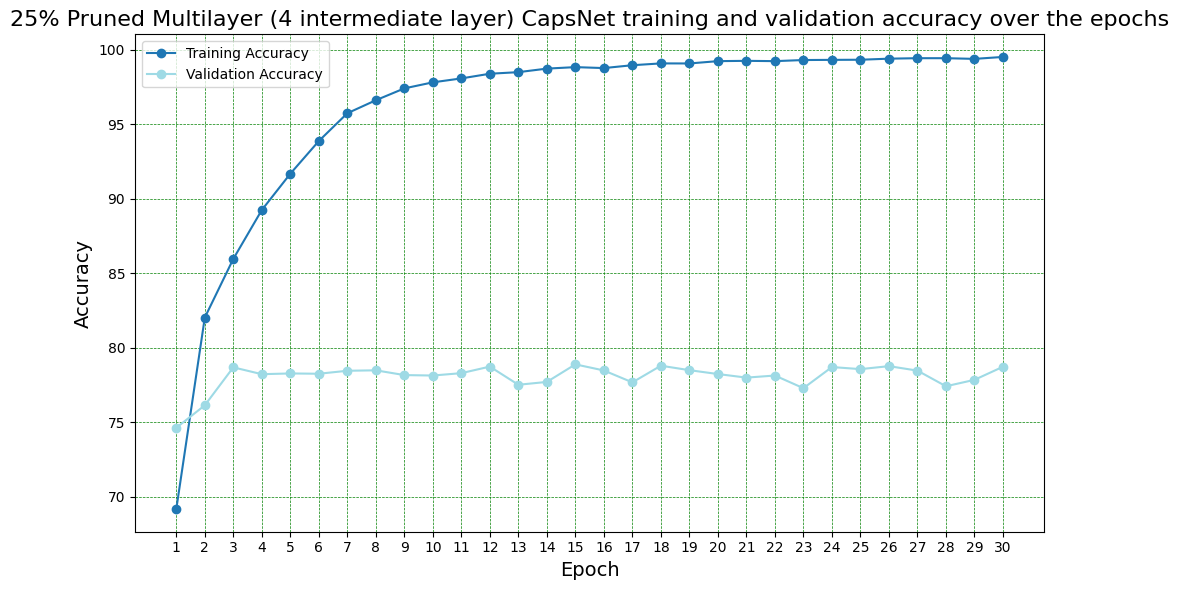

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (4 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=30
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=5

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter5_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter5_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter5_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter5_capsnet_cifar10_model'
pruned_25p_multilayer_inter5_capsnet_cifar10_model = pruned_25p_multilayer_inter5_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_25p_multilayer_inter5_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/26 02:28:20 AM | pruned_25p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7192, Top 1 Acc=12.50, Top 5 Acc=68.75
INFO:capsnet:pruned_25p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7192, Top 1 Acc=12.50, Top 5 Acc=68.75
01/26 02:28:28 AM | pruned_25p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7146, Top 1 Acc=12.31, Top 5 Acc=55.11
INFO:capsnet:pruned_25p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7146, Top 1 Acc=12.31, Top 5 Acc=55.11
01/26 02:28:36 AM | pruned_25p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6797, Top 1 Acc=16.49, Top 5 Acc=59.71
INFO:capsnet:pruned_25p_multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6797, Top 1 Acc=16.49, Top 5 Acc=59.71
01/26 02:28:44 AM | pruned_25p_multilayer_inter5_capsnet_cifar10_model Trai

CPU times: user 3h 14min 26s, sys: 12min 12s, total: 3h 26min 39s
Wall time: 3h 26min 7s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter5_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

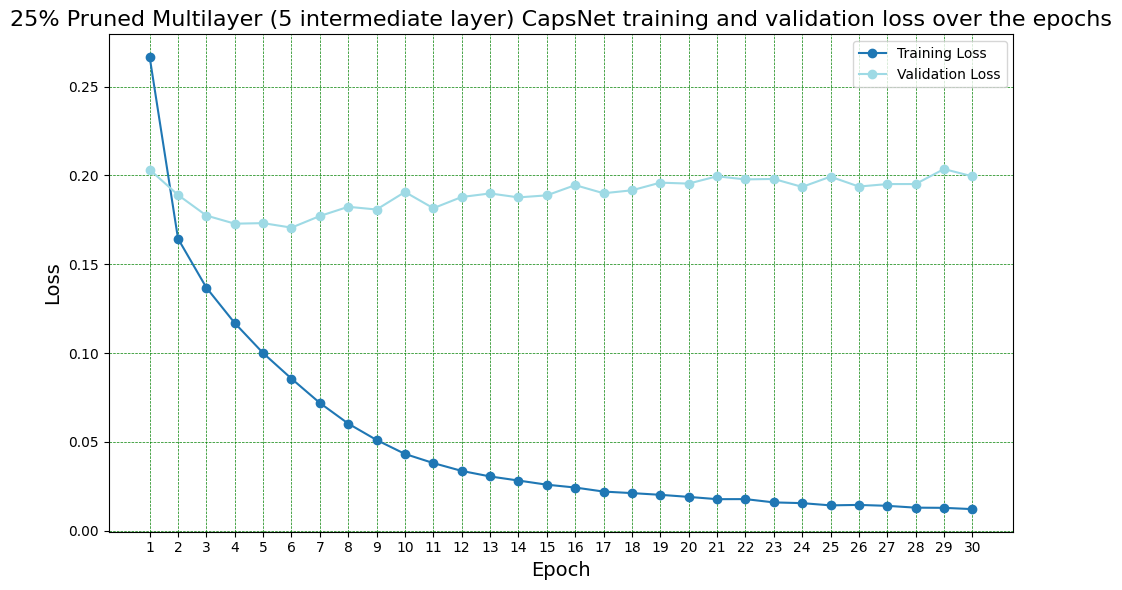

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (5 intermediate layers) CapsNet training and validation loss over the epochs')

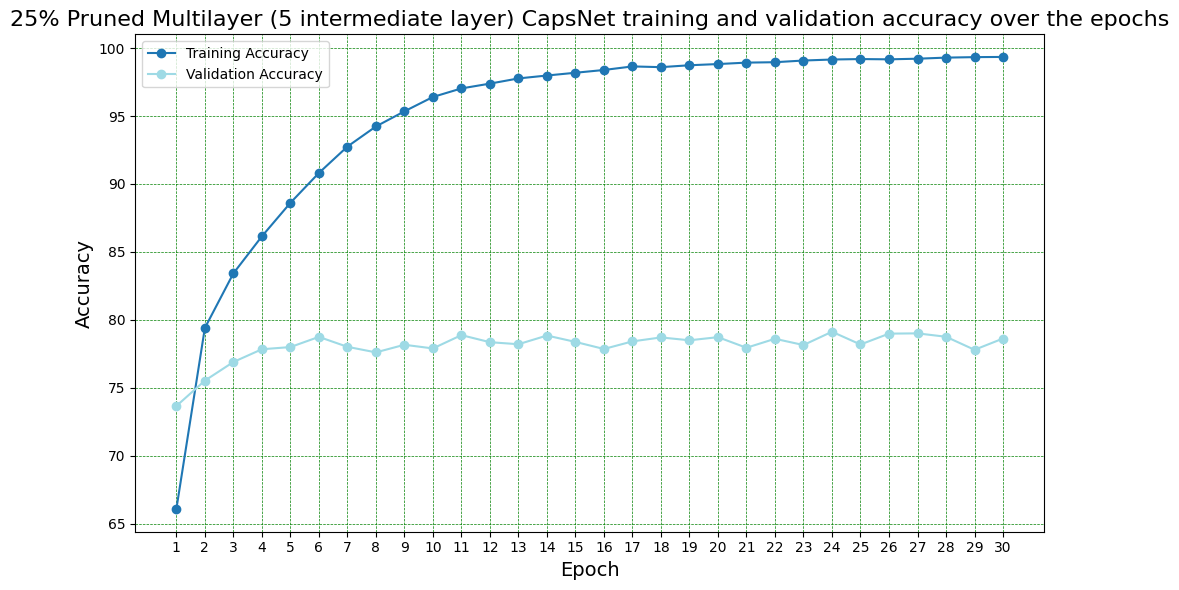

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (5 intermediate layer) CapsNet training and validation accuracy over the epochs')

In [ ]:
from google.colab import runtime
runtime.unassign()

## 6 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=6

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:02<00:00, 68655233.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter6_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter6_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter6_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter6_capsnet_cifar10_model'
pruned_25p_multilayer_inter6_capsnet_cifar10_model = pruned_25p_multilayer_inter6_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_25p_multilayer_inter6_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/26 01:49:23 PM | pruned_25p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7365, Top 1 Acc=3.12, Top 5 Acc=31.25
INFO:capsnet:pruned_25p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7365, Top 1 Acc=3.12, Top 5 Acc=31.25
01/26 01:49:34 PM | pruned_25p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7202, Top 1 Acc=10.61, Top 5 Acc=50.28
INFO:capsnet:pruned_25p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7202, Top 1 Acc=10.61, Top 5 Acc=50.28
01/26 01:49:44 PM | pruned_25p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7017, Top 1 Acc=14.18, Top 5 Acc=55.62
INFO:capsnet:pruned_25p_multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7017, Top 1 Acc=14.18, Top 5 Acc=55.62
01/26 01:49:54 PM | pruned_25p_multilayer_inter6_capsnet_cifar10_model Traini

CPU times: user 2h 2min 9s, sys: 8min 7s, total: 2h 10min 17s
Wall time: 2h 11min 24s


In [ ]:
# from google.colab import runtime
# runtime.unassign()

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

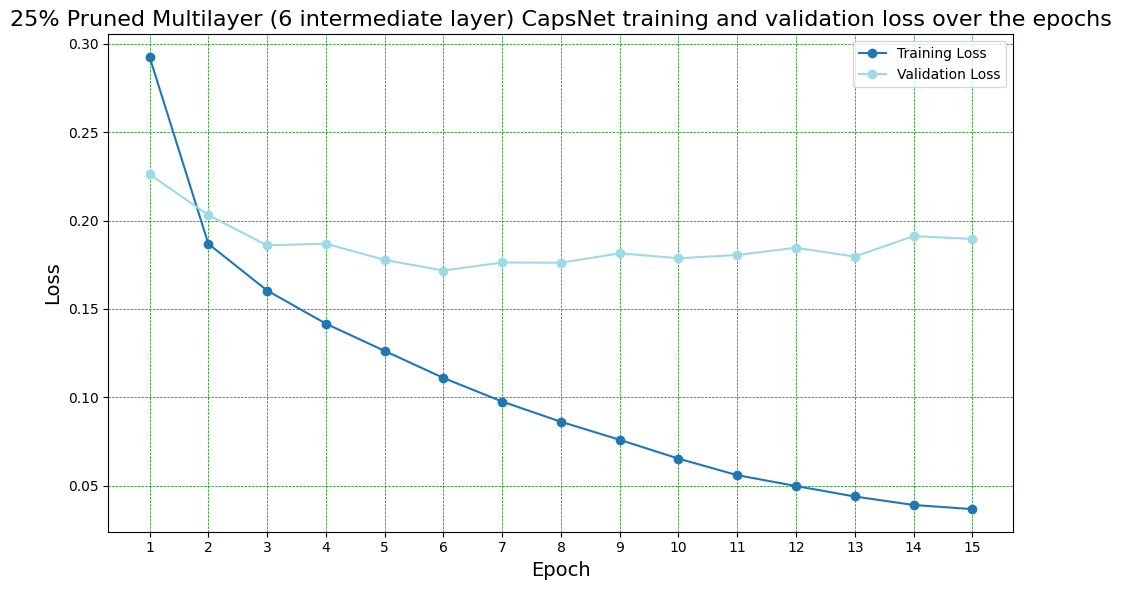

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (6 intermediate layer) CapsNet training and validation loss over the epochs')

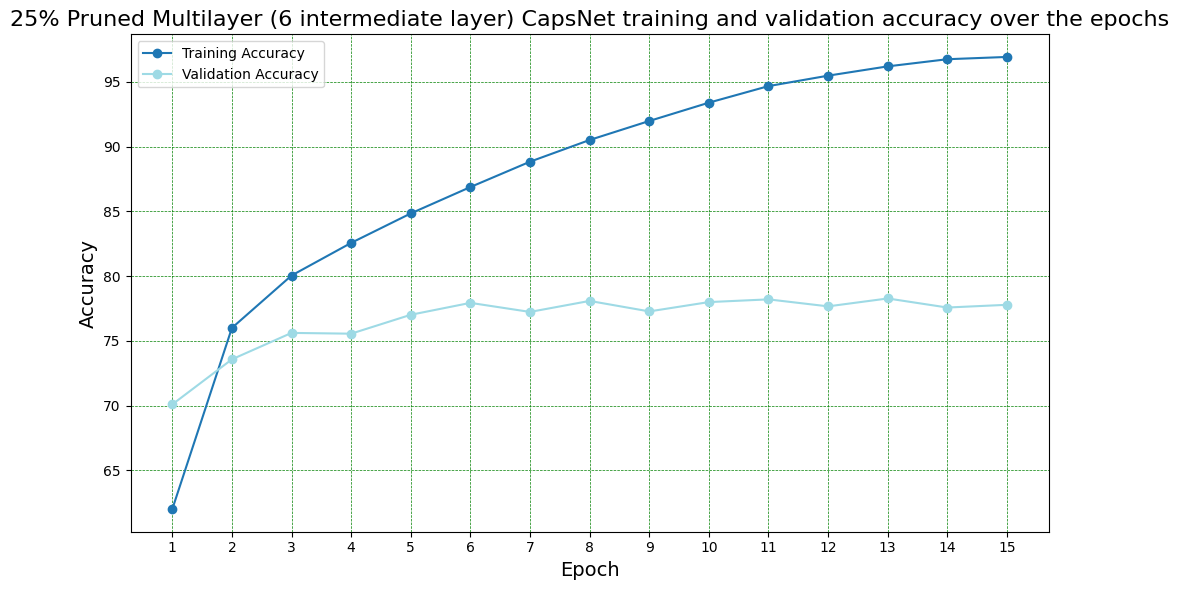

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (6 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=7

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:02<00:00, 68164807.18it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter7_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter7_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter7_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter7_capsnet_cifar10_model'
pruned_25p_multilayer_inter7_capsnet_cifar10_model = pruned_25p_multilayer_inter7_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_25p_multilayer_inter7_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/27 03:34:19 PM | pruned_25p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7281, Top 1 Acc=6.25, Top 5 Acc=59.38
INFO:capsnet:pruned_25p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7281, Top 1 Acc=6.25, Top 5 Acc=59.38
01/27 03:34:28 PM | pruned_25p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7226, Top 1 Acc=10.80, Top 5 Acc=50.85
INFO:capsnet:pruned_25p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7226, Top 1 Acc=10.80, Top 5 Acc=50.85
01/27 03:34:37 PM | pruned_25p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7106, Top 1 Acc=12.45, Top 5 Acc=54.04
INFO:capsnet:pruned_25p_multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7106, Top 1 Acc=12.45, Top 5 Acc=54.04
01/27 03:34:46 PM | pruned_25p_multilayer_inter7_capsnet_cifar10_model Traini

CPU times: user 1h 47min 19s, sys: 7min 44s, total: 1h 55min 4s
Wall time: 1h 54min 47s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

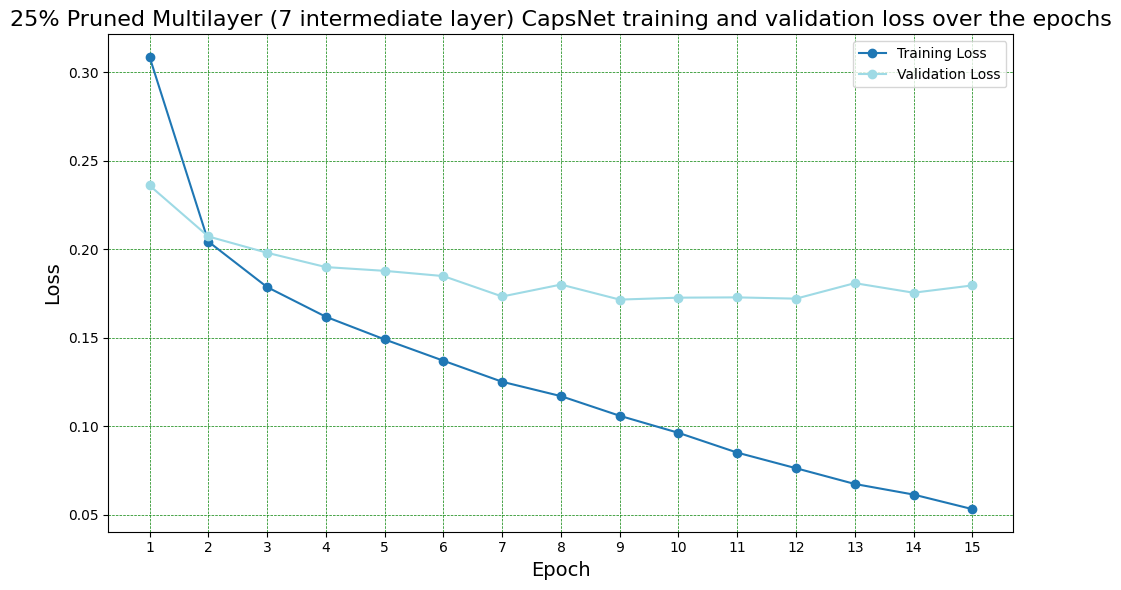

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (7 intermediate layer) CapsNet training and validation loss over the epochs')

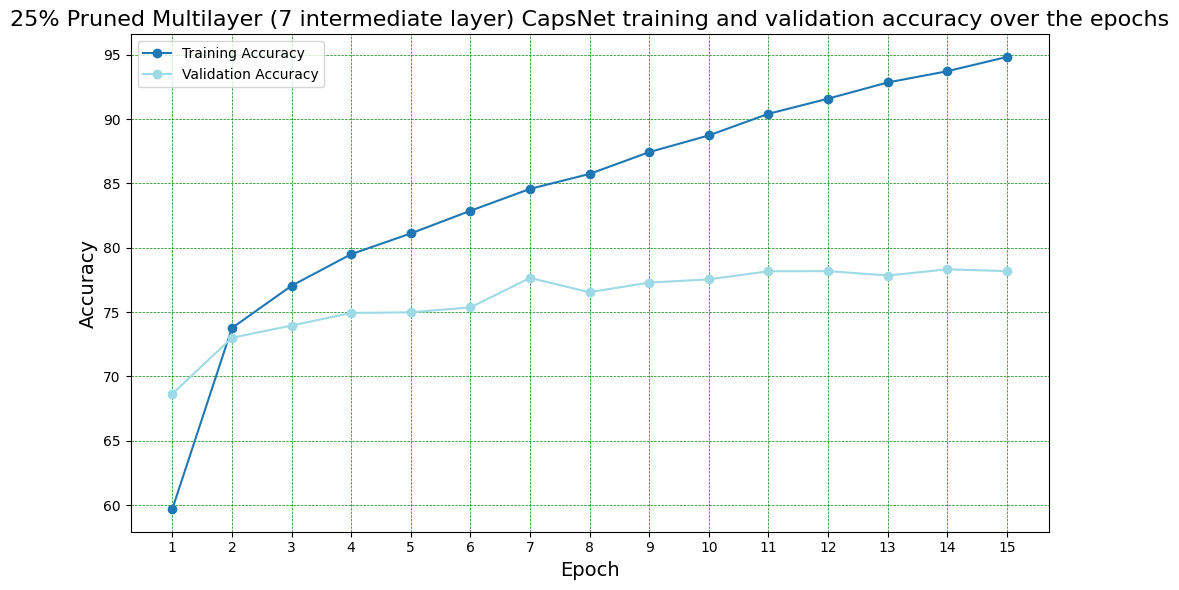

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (7 intermediate layer) CapsNet training and validation accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter8_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter8_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter8_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter8_capsnet_cifar10_model'
pruned_25p_multilayer_inter8_capsnet_cifar10_model = pruned_25p_multilayer_inter8_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  pruned_25p_multilayer_inter8_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

01/27 05:41:00 PM | pruned_25p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7288, Top 1 Acc=9.38, Top 5 Acc=43.75
INFO:capsnet:pruned_25p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7288, Top 1 Acc=9.38, Top 5 Acc=43.75
01/27 05:41:10 PM | pruned_25p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7233, Top 1 Acc=9.94, Top 5 Acc=52.84
INFO:capsnet:pruned_25p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7233, Top 1 Acc=9.94, Top 5 Acc=52.84
01/27 05:41:21 PM | pruned_25p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7161, Top 1 Acc=11.63, Top 5 Acc=54.95
INFO:capsnet:pruned_25p_multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7161, Top 1 Acc=11.63, Top 5 Acc=54.95
01/27 05:41:31 PM | pruned_25p_multilayer_inter8_capsnet_cifar10_model Training

CPU times: user 2h 1min 35s, sys: 8min 39s, total: 2h 10min 15s
Wall time: 2h 9min 54s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

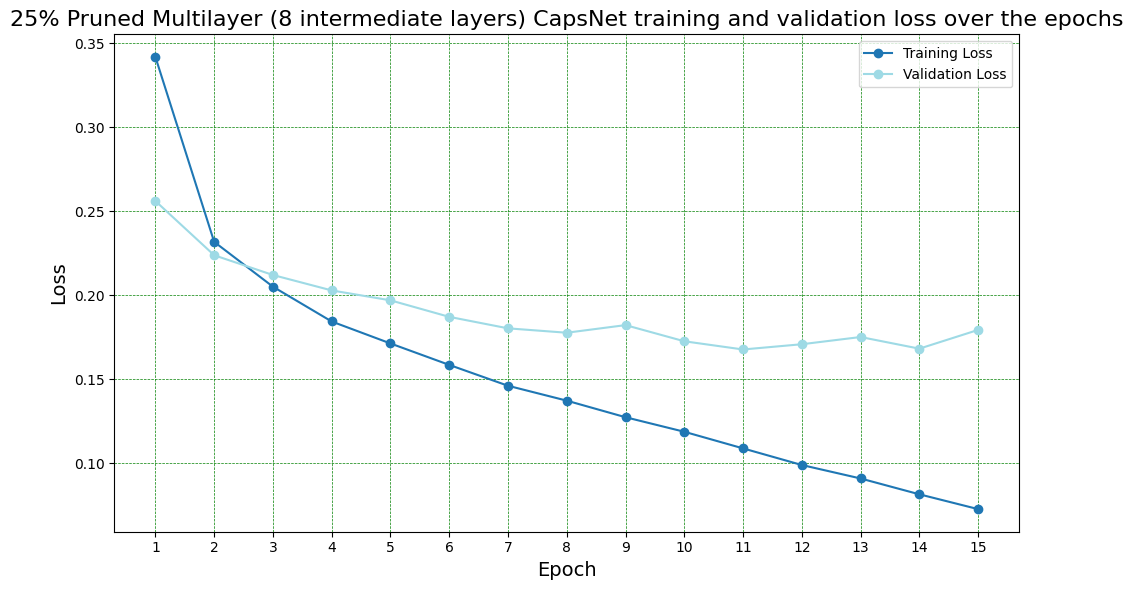

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (8 intermediate layers) CapsNet training and validation loss over the epochs')

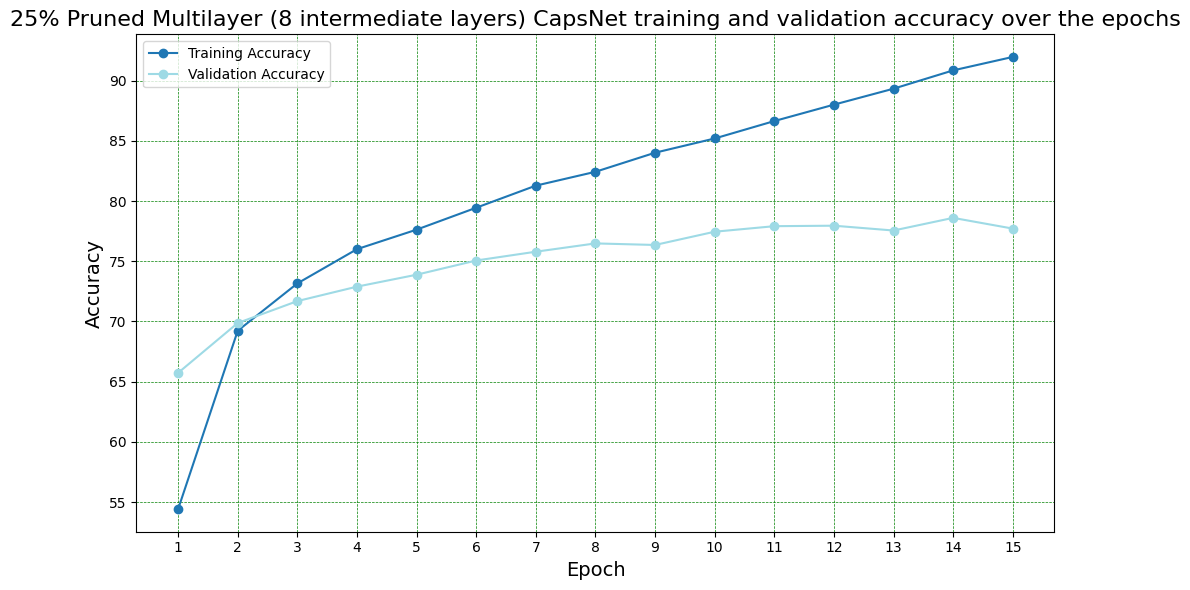

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (8 intermediate layers) CapsNet training and validation accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=9
model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter9_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter9_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter9_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter9_capsnet_cifar10_model'
pruned_25p_multilayer_inter9_capsnet_cifar10_model=pruned_25p_multilayer_inter9_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter9_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/24 10:17:53 PM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7208, Top 1 Acc=12.50, Top 5 Acc=50.00
INFO:capsnet:pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7208, Top 1 Acc=12.50, Top 5 Acc=50.00
01/24 10:18:04 PM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7241, Top 1 Acc=9.28, Top 5 Acc=47.73
INFO:capsnet:pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7241, Top 1 Acc=9.28, Top 5 Acc=47.73
01/24 10:18:15 PM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7196, Top 1 Acc=10.24, Top 5 Acc=50.82
INFO:capsnet:pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7196, Top 1 Acc=10.24, Top 5 Acc=50.82
01/24 10:18:26 PM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Traini

CPU times: user 2h 10min 10s, sys: 9min 16s, total: 2h 19min 27s
Wall time: 2h 19min 16s


Checkpoint restart

In [ ]:
%%time
n_epochs = 30
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter9_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

01/25 12:40:52 AM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1265, Top 1 Acc=84.38, Top 5 Acc=100.00
INFO:capsnet:pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1265, Top 1 Acc=84.38, Top 5 Acc=100.00
01/25 12:41:03 AM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0921, Top 1 Acc=89.30, Top 5 Acc=99.53
INFO:capsnet:pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0921, Top 1 Acc=89.30, Top 5 Acc=99.53
01/25 12:41:14 AM | pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.0887, Top 1 Acc=89.66, Top 5 Acc=99.38
INFO:capsnet:pruned_25p_multilayer_inter9_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.0887, Top 1 Acc=89.66, Top 5 Acc=99.38
01/25 12:41:25 AM | pruned_25p_multilayer_inter9_capsnet_cifar10_mo

CPU times: user 2h 11min 42s, sys: 9min 23s, total: 2h 21min 6s
Wall time: 2h 20min 46s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter9_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

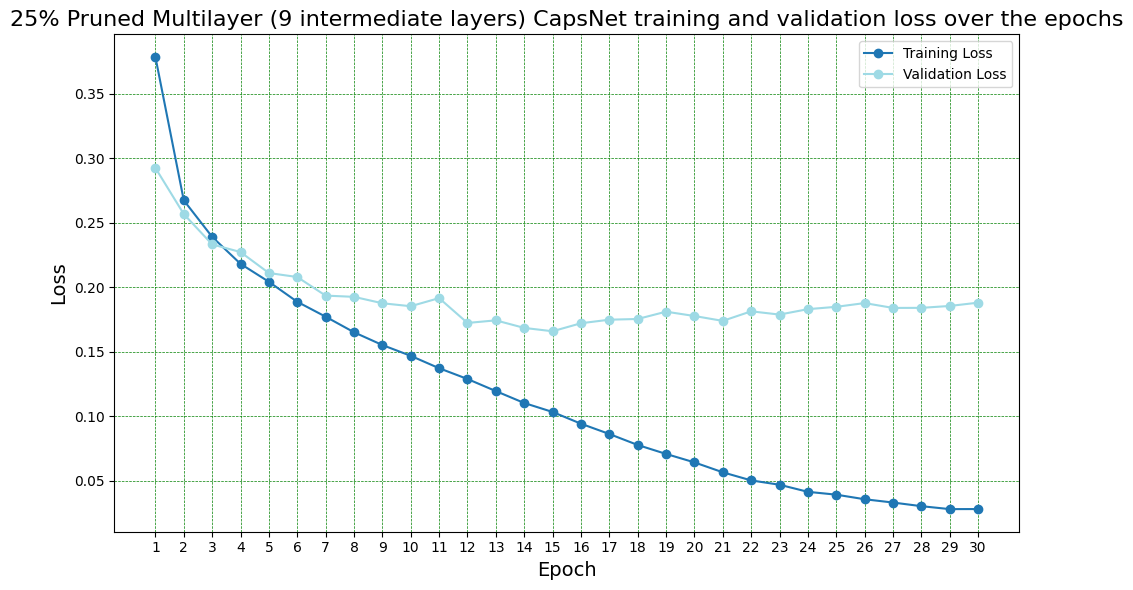

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (9 intermediate layers) CapsNet training and validation loss over the epochs')

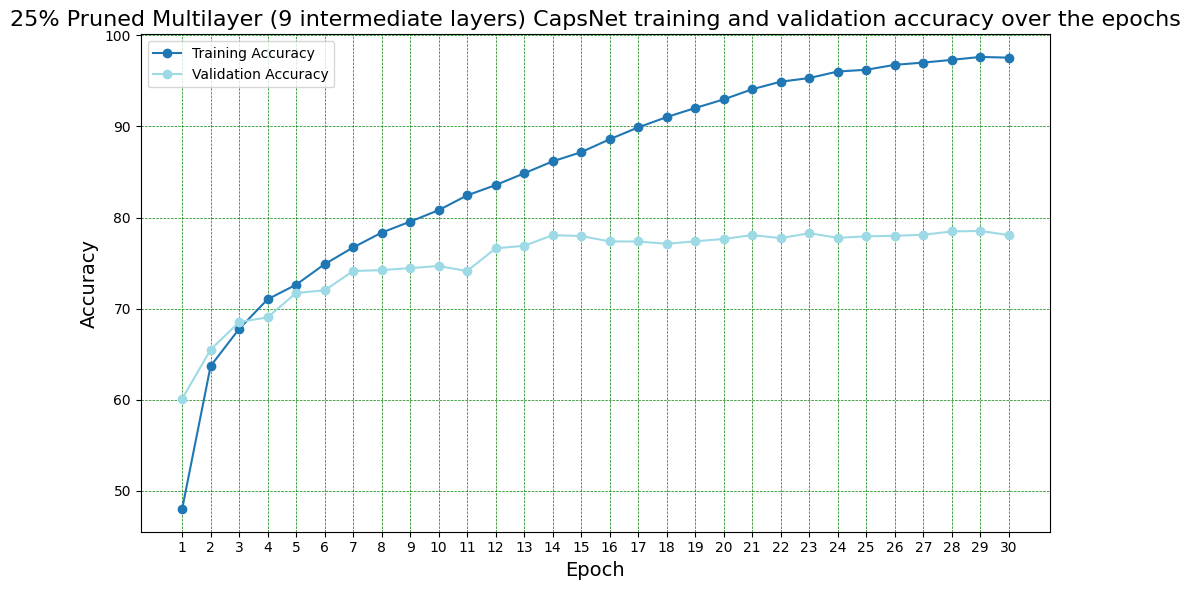

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (9 intermediate layers) CapsNet training and validation accuracy over the epochs')

In [ ]:
# from google.colab import runtime
# runtime.unassign()

## 10 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10
prim_caps_channels=16
prim_caps_dim=12
n_caps_layers=10
model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+"Best_pruned_25pc_base_capsnet_cifar10_model.pt",
                                                    map_location=device)

pruned_25pc_base_capsnet_model_state_dict = pruned_25pc_base_capsnet_cifar10_model['model_state_dict']

In [ ]:
pruned_25p_multilayer_inter10_capsnet_cifar10_model = ccmp.create_pruned_model_from_state_dict(
        new_model=multilayer_inter10_capsnet_cifar10_model,
        saved_state_dict=pruned_25pc_base_capsnet_model_state_dict,
        model_conv_config_dict=model_conv_config,
        n_class=n_class,
        n_caps_layers=n_caps_layers,
        prim_caps_dim=prim_caps_dim)

pruned_25p_multilayer_inter10_capsnet_cifar10_model.name = 'pruned_25p_multilayer_inter10_capsnet_cifar10_model'
pruned_25p_multilayer_inter10_capsnet_cifar10_model=pruned_25p_multilayer_inter10_capsnet_cifar10_model.to(device)
pruned_25p_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/24 04:44:25 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7318, Top 1 Acc=6.25, Top 5 Acc=37.50
INFO:capsnet:pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7318, Top 1 Acc=6.25, Top 5 Acc=37.50
01/24 04:44:38 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7229, Top 1 Acc=10.98, Top 5 Acc=49.81
INFO:capsnet:pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7229, Top 1 Acc=10.98, Top 5 Acc=49.81
01/24 04:44:50 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7217, Top 1 Acc=10.10, Top 5 Acc=49.90
INFO:capsnet:pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.7217, Top 1 Acc=10.10, Top 5 Acc=49.90
01/24 04:45:03 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model

CPU times: user 2h 26min 53s, sys: 10min 21s, total: 2h 37min 14s
Wall time: 2h 37min 2s


Checkpoint restart

In [ ]:
%%time
n_epochs = 30

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                pruned_25p_multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

01/24 07:29:47 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.0641, Top 1 Acc=87.50, Top 5 Acc=100.00
INFO:capsnet:pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.0641, Top 1 Acc=87.50, Top 5 Acc=100.00
01/24 07:30:00 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.1088, Top 1 Acc=86.17, Top 5 Acc=98.48
INFO:capsnet:pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.1088, Top 1 Acc=86.17, Top 5 Acc=98.48
01/24 07:30:12 PM | pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1057, Top 1 Acc=86.49, Top 5 Acc=98.89
INFO:capsnet:pruned_25p_multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1057, Top 1 Acc=86.49, Top 5 Acc=98.89
01/24 07:30:25 PM | pruned_25p_multilayer_inter10_capsnet_cif

CPU times: user 2h 28min 34s, sys: 10min 28s, total: 2h 39min 3s
Wall time: 2h 38min 40s


### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter10_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

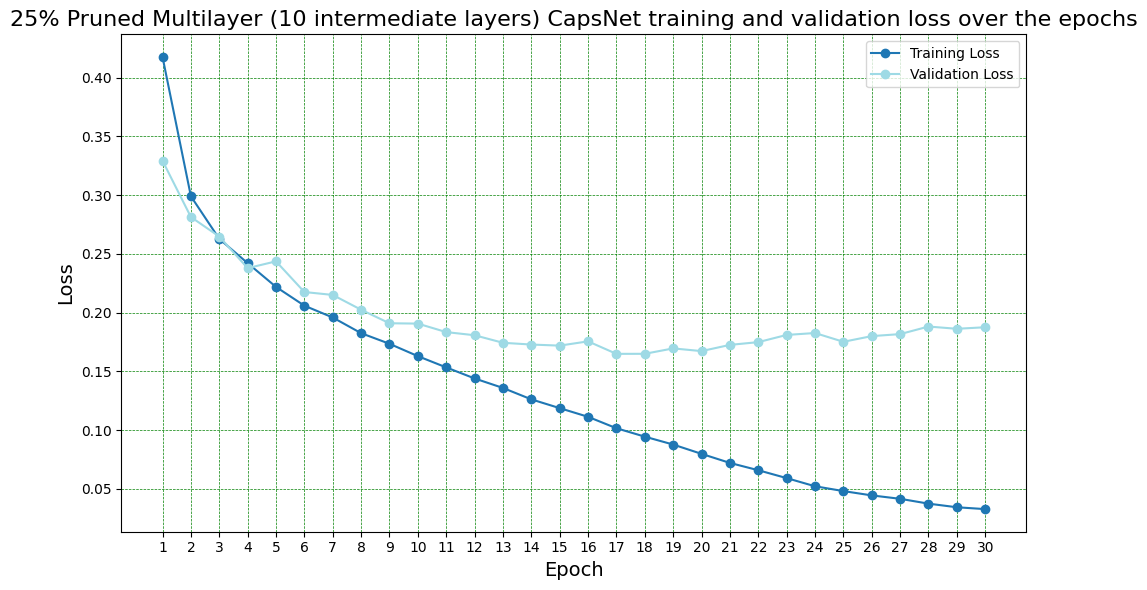

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% Pruned Multilayer (10 intermediate layers) CapsNet training and validation loss over the epochs')

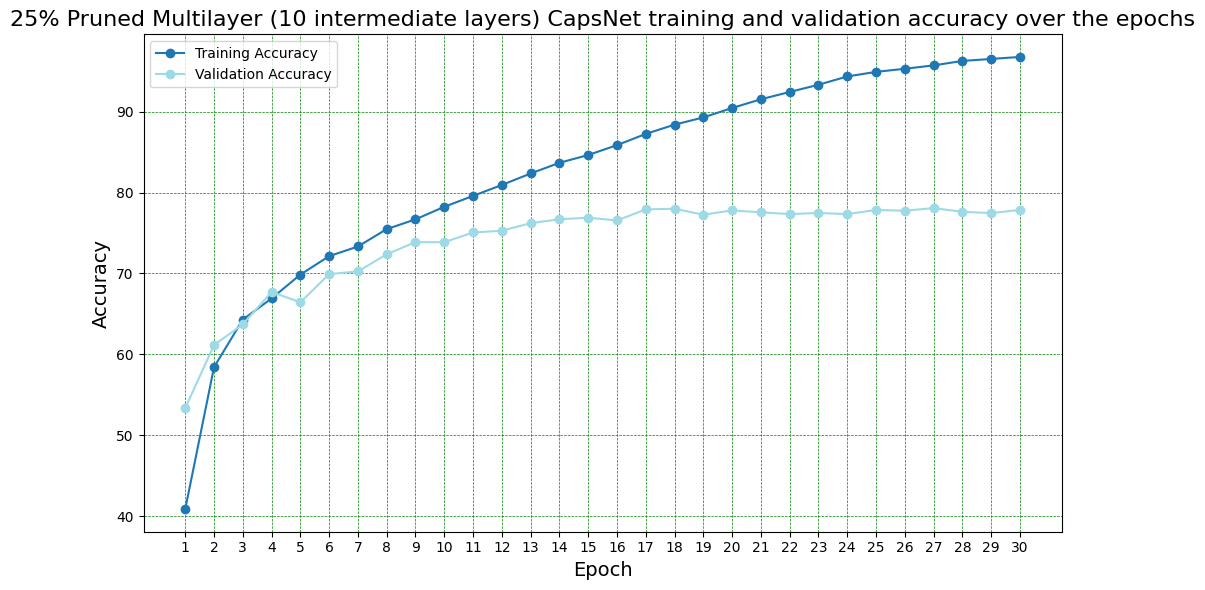

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% Pruned Multilayer (10 intermediate layers) CapsNet training and validation accuracy over the epochs')

## Plots for 25% Pruned Base and All Multilayer CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter1_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter2_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter2_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter3_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter3_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter4_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter4_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter5_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter5_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter6_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter7_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter8_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter9_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter9_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25p_multilayer_inter10_capsnet_cifar10_model_Epoch30_of_30.pt')

In [ ]:
models = [base_capsnet_cifar10_model_data,
          multilayer_capsnet_inter1_model_data,
          multilayer_capsnet_inter2_model_data,
          multilayer_capsnet_inter3_model_data,
          multilayer_capsnet_inter4_model_data,
          multilayer_capsnet_inter5_model_data,
          multilayer_capsnet_inter6_model_data,
          multilayer_capsnet_inter7_model_data,
          multilayer_capsnet_inter8_model_data,
          multilayer_capsnet_inter9_model_data,
          multilayer_capsnet_inter10_model_data]

legends = ['Base',
           '1 InterLayer',
           '2 InterLayers',
           '3 InterLayers',
           '4 InterLayers',
           '5 InterLayers',
           '6 InterLayers',
           '7 InterLayers',
           '8 InterLayers',
           '9 InterLayers',
           '10 InterLayers']

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:15][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :15][1]

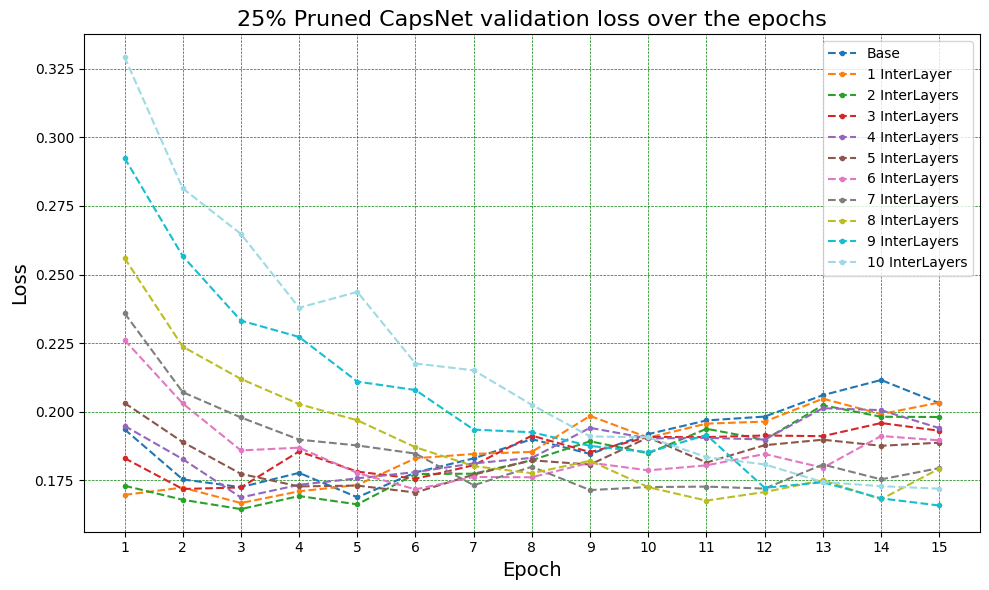

In [ ]:
utils.plot_line_chart(epoch_losses, legends, 'Epoch', 'Loss',
                      '25% Pruned CapsNet validation loss over the epochs', marker='.', line='--')

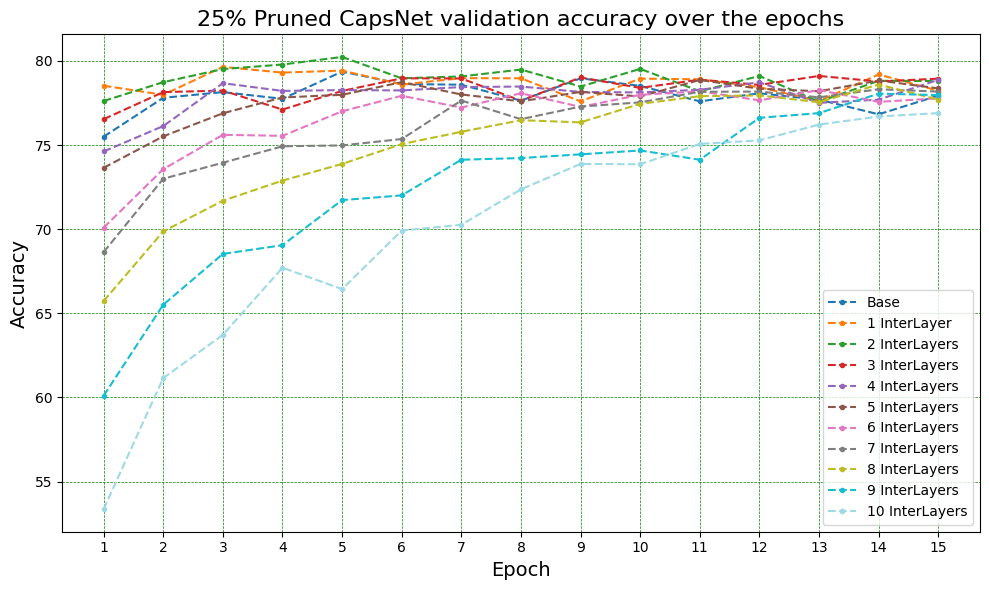

In [ ]:
utils.plot_line_chart(epoch_accuracies, legends, 'Epoch', 'Accuracy',
                      '25% Pruned CapsNet validation accuracy over the epochs', marker='.', line='--')